<a href="https://colab.research.google.com/github/hyunku/Reservoir-Computing/blob/main/ESN_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
from https://mantas.info/code/simple_esn/
(c) 2012-2020 Mantas Lukoševičius
Distributed under MIT license https://opensource.org/licenses/MIT
"""
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import linalg
import sys
# numpy.linalg is also an option for even fewer dependencies

In [ ]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100
data = torch.tensor(np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/MackeyGlass_t17.txt'), dtype=torch.float)
print(data.shape)

torch.Size([10000])


Text(0.5, 1.0, 'A sample of data')

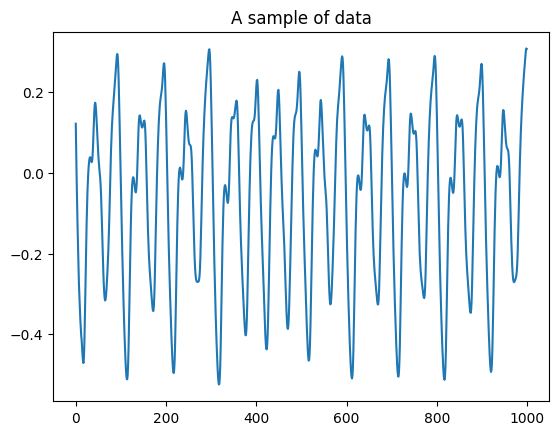

In [ ]:
# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

In [ ]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 900
a = 0.3 # leaking rate, reservoir 뉴런 값 수정률
np.random.seed(42)
torch.manual_seed(0)
Win = (torch.rand(resSize,1+inSize) - 0.5) * 1 # (1000, 2) 행렬 생성 -> (reservoir수, 인풋차원+1) , Weight_In : 인풋 뉴런의 가중치 행렬
W = torch.rand(resSize,resSize) - 0.5 # (1000, 1000) 초기 가중치 행렬 생성(랜덤) -> (reservoir수, reservoir수) : reservoir 뉴런의 학습 가중치 행렬

In [ ]:
def prepare_target(target, seq_lengths, washout, batch_first=False):
    """ Preprocess target for offline training.

    Args:
        target (seq_len, batch, output_size): tensor containing
            the features of the target sequence.
        seq_lengths: list of lengths of each sequence in the batch.
        washout: number of initial timesteps during which output of the
            reservoir is not forwarded to the readout. One value per sample.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``

    Returns:
        tensor containing the features of the batch's sequences rolled out along
        one axis, minus the washouts and the padded values.
    """

    if batch_first:
        target = target.transpose(0, 1)
    n_sequences = target.size(1)
    target_dim = target.size(2)
    train_len = sum(torch.tensor(seq_lengths) - torch.tensor(washout)).item()

    new_target = torch.zeros(train_len, target_dim, device=target.device)

    idx = 0
    for s in range(n_sequences):
        batch_len = seq_lengths[s] - washout[s]
        new_target[idx:idx + batch_len, :] = target[washout[s]:seq_lengths[s], s, :]
        idx += batch_len

    return new_target

In [ ]:
def washout_tensor(tensor, washout, seq_lengths, bidirectional=False, batch_first=False):
    tensor = tensor.transpose(0, 1) if batch_first else tensor.clone()
    if type(seq_lengths) == list:
        seq_lengths = seq_lengths.copy()
    if type(seq_lengths) == torch.Tensor:
        seq_lengths = seq_lengths.clone()

    for b in range(tensor.size(1)):
        if washout[b] > 0:
            tmp = tensor[washout[b]:seq_lengths[b], b].clone()
            tensor[:seq_lengths[b] - washout[b], b] = tmp
            tensor[seq_lengths[b] - washout[b]:, b] = 0
            seq_lengths[b] -= washout[b]

            if bidirectional:
                tensor[seq_lengths[b] - washout[b]:, b] = 0
                seq_lengths[b] -= washout[b]

    if type(seq_lengths) == list:
        max_len = max(seq_lengths)
    else:
        max_len = max(seq_lengths).item()

    return tensor[:max_len], seq_lengths


In [ ]:
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import PackedSequence
import torch.sparse


def apply_permutation(tensor, permutation, dim=1):
    # type: (Tensor, Tensor, int) -> Tensor
    return tensor.index_select(dim, permutation)


class Reservoir(nn.Module):

    def __init__(self, mode, input_size, hidden_size, num_layers, leaking_rate,
                 spectral_radius, w_ih_scale,
                 density, bias=True, batch_first=False):
        super(Reservoir, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.leaking_rate = leaking_rate
        self.spectral_radius = spectral_radius
        self.w_ih_scale = w_ih_scale
        self.density = density
        self.bias = bias
        self.batch_first = batch_first

        self._all_weights = []
        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size

            w_ih = nn.Parameter(torch.Tensor(hidden_size, layer_input_size))
            w_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
            b_ih = nn.Parameter(torch.Tensor(hidden_size))
            layer_params = (w_ih, w_hh, b_ih)

            param_names = ['weight_ih_l{}{}', 'weight_hh_l{}{}']
            if bias:
                param_names += ['bias_ih_l{}{}']
            param_names = [x.format(layer, '') for x in param_names]

            for name, param in zip(param_names, layer_params):
                setattr(self, name, param)
            self._all_weights.append(param_names)

        self.reset_parameters()

    def _apply(self, fn):
        ret = super(Reservoir, self)._apply(fn)
        return ret

    def reset_parameters(self):
        weight_dict = self.state_dict()
        for key, value in weight_dict.items():
            if key == 'weight_ih_l0':
                nn.init.uniform_(value, -1, 1)
                value *= self.w_ih_scale[1:]
            elif re.fullmatch('weight_ih_l[^0]*', key):
                nn.init.uniform_(value, -1, 1)
            elif re.fullmatch('bias_ih_l[0-9]*', key):
                nn.init.uniform_(value, -1, 1)
                value *= self.w_ih_scale[0]
            elif re.fullmatch('weight_hh_l[0-9]*', key):
                w_hh = torch.Tensor(self.hidden_size * self.hidden_size)
                w_hh.uniform_(-1, 1)
                if self.density < 1:
                    zero_weights = torch.randperm(
                        int(self.hidden_size * self.hidden_size))
                    zero_weights = zero_weights[
                                   :int(
                                       self.hidden_size * self.hidden_size * (
                                                   1 - self.density))]
                    w_hh[zero_weights] = 0
                w_hh = w_hh.view(self.hidden_size, self.hidden_size)
                abs_eigs = torch.abs(torch.linalg.eigvals(w_hh))
                weight_dict[key] = w_hh * (self.spectral_radius / torch.max(abs_eigs))

        self.load_state_dict(weight_dict)

    def check_input(self, input, batch_sizes):
        # type: (Tensor, Optional[Tensor]) -> None
        expected_input_dim = 2 if batch_sizes is not None else 3
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                'input must have {} dimensions, got {}'.format(
                    expected_input_dim, input.dim()))
        if self.input_size != input.size(-1):
            raise RuntimeError(
                'input.size(-1) must be equal to input_size. Expected {}, got {}'.format(
                    self.input_size, input.size(-1)))

    def get_expected_hidden_size(self, input, batch_sizes):
        # type: (Tensor, Optional[Tensor]) -> Tuple[int, int, int]
        if batch_sizes is not None:
            mini_batch = batch_sizes[0]
            mini_batch = int(mini_batch)
        else:
            mini_batch = input.size(0) if self.batch_first else input.size(1)
        expected_hidden_size = (self.num_layers, mini_batch, self.hidden_size)
        return expected_hidden_size

    def check_hidden_size(self, hx, expected_hidden_size, msg='Expected hidden size {}, got {}'):
        # type: (Tensor, Tuple[int, int, int], str) -> None
        if hx.size() != expected_hidden_size:
            raise RuntimeError(msg.format(expected_hidden_size, tuple(hx.size())))

    def check_forward_args(self, input, hidden, batch_sizes):
        # type: (Tensor, Tensor, Optional[Tensor]) -> None
        self.check_input(input, batch_sizes)
        expected_hidden_size = self.get_expected_hidden_size(input, batch_sizes)

        self.check_hidden_size(hidden, expected_hidden_size)

    def permute_hidden(self, hx, permutation):
        # type: (Tensor, Optional[Tensor]) -> Tensor
        if permutation is None:
            return hx
        return apply_permutation(hx, permutation)

    def forward(self, input, hx=None):
        is_packed = isinstance(input, PackedSequence)
        if is_packed:
            input, batch_sizes, sorted_indices, unsorted_indices = input
            max_batch_size = int(batch_sizes[0])
        else:
            batch_sizes = None
            max_batch_size = input.size(0) if self.batch_first else input.size(1)
            sorted_indices = None
            unsorted_indices = None

        if hx is None:
            hx = input.new_zeros(self.num_layers, max_batch_size,
                                 self.hidden_size, requires_grad=False)
        else:
            # Each batch of the hidden state should match the input sequence that
            # the user believes he/she is passing in.
            hx = self.permute_hidden(hx, sorted_indices)

        flat_weight = None

        self.check_forward_args(input, hx, batch_sizes)
        func = AutogradReservoir(
            self.mode,
            self.input_size,
            self.hidden_size,
            num_layers=self.num_layers,
            batch_first=self.batch_first,
            train=self.training,
            variable_length=is_packed,
            flat_weight=flat_weight,
            leaking_rate=self.leaking_rate
        )
        output, hidden = func(input, self.all_weights, hx, batch_sizes)
        if is_packed:
            output = PackedSequence(output, batch_sizes, sorted_indices, unsorted_indices)
        return output, self.permute_hidden(hidden, unsorted_indices)

    def extra_repr(self):
        s = '({input_size}, {hidden_size}'
        if self.num_layers != 1:
            s += ', num_layers={num_layers}'
        if self.bias is not True:
            s += ', bias={bias}'
        if self.batch_first is not False:
            s += ', batch_first={batch_first}'
        s += ')'
        return s.format(**self.__dict__)

    def __setstate__(self, d):
        super(Reservoir, self).__setstate__(d)
        self.__dict__.setdefault('_data_ptrs', [])
        if 'all_weights' in d:
            self._all_weights = d['all_weights']
        if isinstance(self._all_weights[0][0], str):
            return
        num_layers = self.num_layers
        self._all_weights = []
        for layer in range(num_layers):
            weights = ['weight_ih_l{}{}', 'weight_hh_l{}{}', 'bias_ih_l{}{}']
            weights = [x.format(layer) for x in weights]
            if self.bias:
                self._all_weights += [weights]
            else:
                self._all_weights += [weights[:2]]

    @property
    def all_weights(self):
        return [[getattr(self, weight) for weight in weights] for weights in
                self._all_weights]

In [ ]:
def AutogradReservoir(mode, input_size, hidden_size, num_layers=1,
                      batch_first=False, train=True,
                      batch_sizes=None, variable_length=False, flat_weight=None,
                      leaking_rate=1):
    if mode == 'RES_TANH':
        cell = ResTanhCell
    elif mode == 'RES_RELU':
        cell = ResReLUCell
    elif mode == 'RES_ID':
        cell = ResIdCell

    if variable_length:
        layer = (VariableRecurrent(cell, leaking_rate),)
    else:
        layer = (Recurrent(cell, leaking_rate),)

    func = StackedRNN(layer,
                      num_layers,
                      False,
                      train=train)

    def forward(input, weight, hidden, batch_sizes):
        if batch_first and batch_sizes is None:
            input = input.transpose(0, 1)

        nexth, output = func(input, hidden, weight, batch_sizes)

        if batch_first and not variable_length:
            output = output.transpose(0, 1)

        return output, nexth

    return forward

In [ ]:
def Recurrent(inner, leaking_rate):
    def forward(input, hidden, weight, batch_sizes):
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = inner(input[i], hidden, leaking_rate, *weight)
            # hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())

        return hidden, output

    return forward

In [ ]:
def VariableRecurrent(inner, leaking_rate):
    def forward(input, hidden, weight, batch_sizes):
        output = []
        input_offset = 0
        last_batch_size = batch_sizes[0]
        hiddens = []
        flat_hidden = not isinstance(hidden, tuple)
        if flat_hidden:
            hidden = (hidden,)
        for batch_size in batch_sizes:
            step_input = input[input_offset:input_offset + batch_size]
            input_offset += batch_size

            dec = last_batch_size - batch_size
            if dec > 0:
                hiddens.append(tuple(h[-dec:] for h in hidden))
                hidden = tuple(h[:-dec] for h in hidden)
            last_batch_size = batch_size

            if flat_hidden:
                hidden = (inner(step_input, hidden[0], leaking_rate, *weight),)
            else:
                hidden = inner(step_input, hidden, leaking_rate, *weight)

            output.append(hidden[0])
        hiddens.append(hidden)
        hiddens.reverse()

        hidden = tuple(torch.cat(h, 0) for h in zip(*hiddens))
        assert hidden[0].size(0) == batch_sizes[0]
        if flat_hidden:
            hidden = hidden[0]
        output = torch.cat(output, 0)

        return hidden, output

    return forward

In [ ]:
def StackedRNN(inners, num_layers, lstm=False, train=True):
    num_directions = len(inners)
    total_layers = num_layers * num_directions

    def forward(input, hidden, weight, batch_sizes):
        assert (len(weight) == total_layers)
        next_hidden = []
        all_layers_output = []

        for i in range(num_layers):
            all_output = []
            for j, inner in enumerate(inners):
                l = i * num_directions + j

                hy, output = inner(input, hidden[l], weight[l], batch_sizes)
                next_hidden.append(hy)
                all_output.append(output)

            input = torch.cat(all_output, input.dim() - 1)
            all_layers_output.append(input)

        all_layers_output = torch.cat(all_layers_output, -1)
        next_hidden = torch.cat(next_hidden, 0).view(
            total_layers, *next_hidden[0].size())

        return next_hidden, all_layers_output

    return forward

In [ ]:
def ResTanhCell(input, hidden, leaking_rate, w_ih, w_hh, b_ih=None):
    hy_ = torch.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh))
    hy = (1 - leaking_rate) * hidden + leaking_rate * hy_
    return hy


def ResReLUCell(input, hidden, leaking_rate, w_ih, w_hh, b_ih=None):
    hy_ = F.relu(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh))
    hy = (1 - leaking_rate) * hidden + leaking_rate * hy_
    return hy


def ResIdCell(input, hidden, leaking_rate, w_ih, w_hh, b_ih=None):
    hy_ = F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh)
    hy = (1 - leaking_rate) * hidden + leaking_rate * hy_
    return hy

In [ ]:
class ESN(nn.Module):
    """ Applies an Echo State Network to an input sequence. Multi-layer Echo
    State Network is based on paper
    Deep Echo State Network (DeepESN): A Brief Survey - Gallicchio, Micheli 2017

    Args:
        input_size: The number of expected features in the input x.
        hidden_size: The number of features in the hidden state h.
        output_size: The number of expected features in the output y.
        num_layers: Number of recurrent layers. Default: 1
        nonlinearity: The non-linearity to use ['tanh'|'relu'|'id'].
            Default: 'tanh'
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        leaking_rate: Leaking rate of reservoir's neurons. Default: 1
        spectral_radius: Desired spectral radius of recurrent weight matrix.
            Default: 0.9
        w_ih_scale: Scale factor for first layer's input weights (w_ih_l0). It
            can be a number or a tensor of size '1 + input_size' and first element
            is the bias' scale factor. Default: 1
        lambda_reg: Ridge regression's shrinkage parameter. Default: 1
        density: Recurrent weight matrix's density. Default: 1
        w_io: If 'True', then the network uses trainable input-to-output
            connections. Default: ``False``
        readout_training: Readout's traning algorithm ['gd'|'svd'|'cholesky'|'inv'].
            If 'gd', gradients are accumulated during backward
            pass. If 'svd', 'cholesky' or 'inv', the network will learn readout's
            parameters during the forward pass using ridge regression. The
            coefficients are computed using SVD, Cholesky decomposition or
            standard ridge regression formula. 'gd', 'cholesky' and 'inv'
            permit the usage of mini-batches to train the readout.
            If 'inv' and matrix is singular, pseudoinverse is used.
        output_steps: defines how the reservoir's output will be used by ridge
            regression method ['all', 'mean', 'last'].
            If 'all', the entire reservoir output matrix will be used.
            If 'mean', the mean of reservoir output matrix along the timesteps
            dimension will be used.
            If 'last', only the last timestep of the reservoir output matrix
            will be used.
            'mean' and 'last' are useful for classification tasks.

    Inputs: input, washout, h_0, target
        input (seq_len, batch, input_size): tensor containing the features of
            the input sequence. The input can also be a packed variable length
            sequence. See `torch.nn.utils.rnn.pack_padded_sequence`
        washout (batch): number of initial timesteps during which output of the
            reservoir is not forwarded to the readout. One value per batch's
            sample.
        h_0 (num_layers, batch, hidden_size): tensor containing
             the initial reservoir's hidden state for each element in the batch.
             Defaults to zero if not provided.

        target (seq_len*batch - washout*batch, output_size): tensor containing
            the features of the batch's target sequences rolled out along one
            axis, minus the washouts and the padded values. It is only needed
            for readout's training in offline mode. Use `prepare_target` to
            compute it.

    Outputs: output, h_n
        - output (seq_len, batch, hidden_size): tensor containing the output
        features (h_k) from the readout, for each k.
        - **h_n** (num_layers * num_directions, batch, hidden_size): tensor
          containing the reservoir's hidden state for k=seq_len.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1,
                 nonlinearity='tanh', batch_first=False, leaking_rate=1,
                 spectral_radius=0.9, w_ih_scale=1, lambda_reg=0, density=1,
                 w_io=False, readout_training='svd', output_steps='all'):
        super(ESN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        if nonlinearity == 'tanh':
            mode = 'RES_TANH'
        elif nonlinearity == 'relu':
            mode = 'RES_RELU'
        elif nonlinearity == 'id':
            mode = 'RES_ID'
        else:
            raise ValueError("Unknown nonlinearity '{}'".format(nonlinearity))
        self.batch_first = batch_first
        self.leaking_rate = leaking_rate
        self.spectral_radius = spectral_radius
        if type(w_ih_scale) != torch.Tensor:
            self.w_ih_scale = torch.ones(input_size + 1)
            self.w_ih_scale *= w_ih_scale
        else:
            self.w_ih_scale = w_ih_scale

        self.lambda_reg = lambda_reg
        self.density = density
        self.w_io = w_io
        if readout_training in {'gd', 'svd', 'cholesky', 'inv'}:
            self.readout_training = readout_training
        else:
            raise ValueError("Unknown readout training algorithm '{}'".format(
                readout_training))

        self.reservoir = Reservoir(mode, input_size, hidden_size, num_layers,
                                   leaking_rate, spectral_radius,
                                   self.w_ih_scale, density,
                                   batch_first=batch_first)

        if w_io:
            self.readout = nn.Linear(input_size + hidden_size * num_layers,
                                     output_size)
        else:
            self.readout = nn.Linear(hidden_size * num_layers, output_size)
        if readout_training == 'offline':
            self.readout.weight.requires_grad = False

        if output_steps in {'all', 'mean', 'last'}:
            self.output_steps = output_steps
        else:
            raise ValueError("Unknown task '{}'".format(
                output_steps))

        self.XTX = None
        self.XTy = None
        self.X = None

    def forward(self, input, washout, h_0=None, target=None):
        with torch.no_grad():
            self.washout = washout
            is_packed = isinstance(input, PackedSequence)

            output, hidden = self.reservoir(input, h_0)
            self.save_output = output
            self.save_hidden = hidden
            if is_packed:
                output, seq_lengths = pad_packed_sequence(output,
                                                          batch_first=self.batch_first)
            else:
                if self.batch_first:
                    seq_lengths = output.size(0) * [output.size(1)]
                else:
                    seq_lengths = output.size(1) * [output.size(0)]

            if self.batch_first:
                output = output.transpose(0, 1)

            output, seq_lengths = washout_tensor(output, washout, seq_lengths)

            if self.w_io:
                if is_packed:
                    input, input_lengths = pad_packed_sequence(input,
                                                          batch_first=self.batch_first)
                else:
                    input_lengths = [input.size(0)] * input.size(1)

                if self.batch_first:
                    input = input.transpose(0, 1)

                input, _ = washout_tensor(input, washout, input_lengths)
                output = torch.cat([input, output], -1)

            if self.readout_training == 'gd' or target is None:
                with torch.enable_grad():
                    output = self.readout(output)

                    if is_packed:
                        for i in range(output.size(1)):
                            if seq_lengths[i] < output.size(0):
                                output[seq_lengths[i]:, i] = 0

                    if self.batch_first:
                        output = output.transpose(0, 1)

                    # Uncomment if you want packed output.
                    # if is_packed:
                    #     output = pack_padded_sequence(output, seq_lengths,
                    #                                   batch_first=self.batch_first)

                    return output, hidden

            else:
                batch_size = output.size(1)

                X = torch.ones(target.size(0), 1 + output.size(2), device=target.device)
                row = 0
                for s in range(batch_size):
                    if self.output_steps == 'all':
                        X[row:row + seq_lengths[s], 1:] = output[:seq_lengths[s],
                                                          s]
                        row += seq_lengths[s]
                    elif self.output_steps == 'mean':
                        X[row, 1:] = torch.mean(output[:seq_lengths[s], s], 0)
                        row += 1
                    elif self.output_steps == 'last':
                        X[row, 1:] = output[seq_lengths[s] - 1, s]
                        row += 1

                if self.readout_training == 'cholesky':
                    if self.XTX is None:
                        self.XTX = torch.mm(X.t(), X)
                        self.XTy = torch.mm(X.t(), target)
                    else:
                        self.XTX += torch.mm(X.t(), X)
                        self.XTy += torch.mm(X.t(), target)

                elif self.readout_training == 'svd':
                    # Scikit-Learn SVD solver for ridge regression.
                    U, s, V = torch.svd(X)
                    idx = s > 1e-15  # same default value as scipy.linalg.pinv
                    s_nnz = s[idx][:, None]
                    UTy = torch.mm(U.t(), target)
                    d = torch.zeros(s.size(0), 1, device=X.device)
                    d[idx] = s_nnz / (s_nnz ** 2 + self.lambda_reg)
                    d_UT_y = d * UTy
                    W = torch.mm(V, d_UT_y).t()

                    self.readout.bias = nn.Parameter(W[:, 0])
                    self.readout.weight = nn.Parameter(W[:, 1:])
                elif self.readout_training == 'inv':
                    self.X = X
                    if self.XTX is None:
                        self.XTX = torch.mm(X.t(), X)
                        self.XTy = torch.mm(X.t(), target)
                    else:
                        self.XTX += torch.mm(X.t(), X)
                        self.XTy += torch.mm(X.t(), target)

                return None, None

    def fit(self, xtx=None, washout=None, xty=None, epoch=100):
        if self.readout_training in {'gd', 'svd'}:
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(self.parameters(), 
                                         lr=0.0002)
            for idx in range(epoch):
                pred = self.forward(xtx, washout)
                label = xty
                
                loss = criterion(pred[0].squeeze(1), label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            return

        if self.readout_training == 'cholesky':
            reg = self.lambda_reg
            X = self.XTX
            Yt = self.XTy
            mat_a = torch.tensor(torch.matmul(X,X.T) + reg*torch.eye(inSize+self.hidden_size), dtype=torch.float32)
            mat_b = torch.tensor(torch.matmul(X,Yt), dtype=torch.float32)
            Wout = torch.matmul(torch.linalg.inv(mat_a), mat_b).T # (1,1002)
#             W = torch.linalg.solve(self.XTy,
#                                    self.XTX + self.lambda_reg * torch.eye(
#                                        self.XTX.size(0), device=self.XTX.device))[0].t()
            self.XTX = None
            self.XTy = None
            W = Wout
            print(W.shape)
            self.readout.bias = nn.Parameter(W[:, 0])
            self.readout.weight = nn.Parameter(W[:, 1:])
        elif self.readout_training == 'inv':
            I = (self.lambda_reg * torch.eye(self.XTX.size(0))).to(
                self.XTX.device)
            A = self.XTX + I
            X_rank = torch.linalg.matrix_rank(A).item()

            if X_rank == self.X.size(0):
                W = torch.mm(torch.inverse(A), self.XTy).t()
            else:
                W = torch.mm(torch.pinverse(A), self.XTy).t()

            self.readout.bias = nn.Parameter(W[:, 0])
            self.readout.weight = nn.Parameter(W[:, 1:])

            self.XTX = None
            self.XTy = None

    def reset_parameters(self):
        self.reservoir.reset_parameters()
        self.readout.reset_parameters()


In [ ]:
# 만드는중...

class ESNAE(nn.Module):
    def __init__(self, input_dim, resSize, outSize):
        super(ESNAE, self).__init__()

        self.encoder = ESN(inSize, resSize, outSize, readout_training="gd")
        self.decoder = ESN(inSize, 900, outSize, readout_training="inv")

    def forward(self, inputx, washout, h_0=None, target=None):
        latent, hidden_en = self.encoder(inputx, washout, h_0, target)
        output, hidden_de = self.decoder(latent, washout, hidden_en, target)
        return output, hidden_de
    
    def fit_encoder(self, xtx=None, washout=None, xty=None, epoch=100):
        self.encoder.fit(xtx, washout, xty, epoch)
    
    def fit_decoder(self, xtx=None, washout=None, xty=None):
        latent, hidden_en = self.encoder(xtx, washout, None, None)
        self.decoder.fit(latent, washout, xty)

In [ ]:
Xt = data[None,initLen+0:trainLen+0].reshape(-1, 1, 1)
Yt = data[None,initLen+1:trainLen+1].reshape(-1, 1, 1)
Xs = data[None,initLen+0+trainLen:trainLen+testLen+0].reshape(-1, 1, 1)
Ys = data[None,initLen+1+trainLen:trainLen+testLen+1].reshape(-1, 1, 1)

washout = [resSize]
loss_fcn = torch.nn.MSELoss()

In [ ]:
print(Xt.shape)
print(Xs.shape)
print(Yt.shape)
print(Ys.shape)

torch.Size([1900, 1, 1])
torch.Size([1900, 1, 1])
torch.Size([1900, 1, 1])
torch.Size([1900, 1, 1])


In [ ]:
print(inSize, resSize, outSize)

1 900 1


In [ ]:
# Training
trY_flat = prepare_target(Yt.clone(), [Xt.size(0)], washout)

model = ESNAE(inSize, resSize, outSize)

model(Xt, washout, None, trY_flat)
model.fit_encoder(Xt, washout, trY_flat, epoch=300)
model(Xt, washout, None, trY_flat)
model.fit_decoder(Xt, washout, trY_flat)
output, hidden = model(Xt, washout)

# Test
output, hidden = model(Xs, [0], hidden)
mse = loss_fcn(output, Ys)
print('MSE = ', mse.item())

MSE =  0.12582121789455414


In [ ]:
hidden.shape

torch.Size([1, 1, 900])

In [ ]:
X = model.encoder.save_output.squeeze().detach().numpy()

In [ ]:
Wout = np.concatenate([[[1]], [model.encoder.readout.bias.detach().numpy()], model.encoder.readout.weight.detach().numpy()], axis=1)

In [ ]:
Xt.shape

torch.Size([1900, 1, 1])

In [ ]:
output.shape

torch.Size([1900, 1, 1])

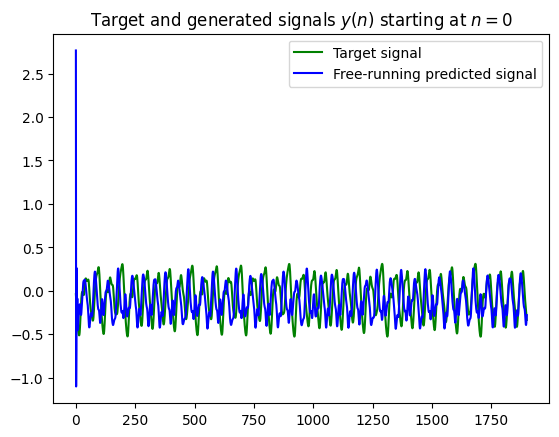

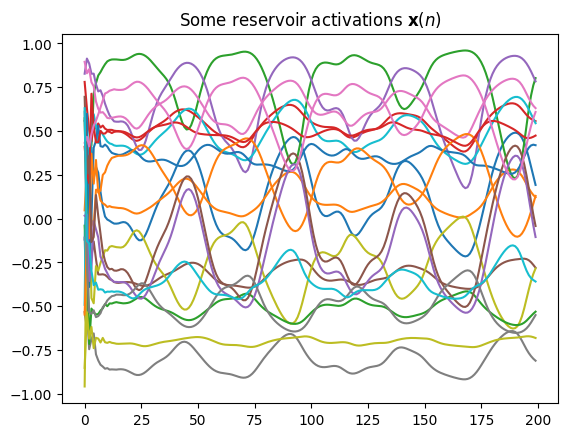

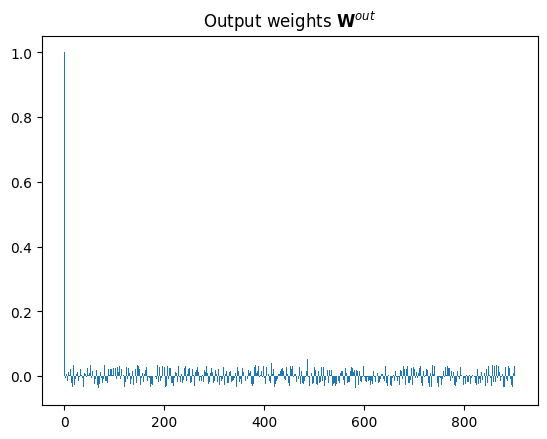

In [ ]:
# plot some signals
plt.figure(1).clear()
plt.plot( Xt.squeeze().numpy(), 'g' )
plt.plot( output.squeeze().detach().numpy(), 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])


plt.figure(2).clear()
plt.plot( X[0:200,0:20] )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()